# 👖 Autoencoders on Fashion MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [16]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

## 1. Prepare the data <a name="prepare"></a>

In [17]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [18]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

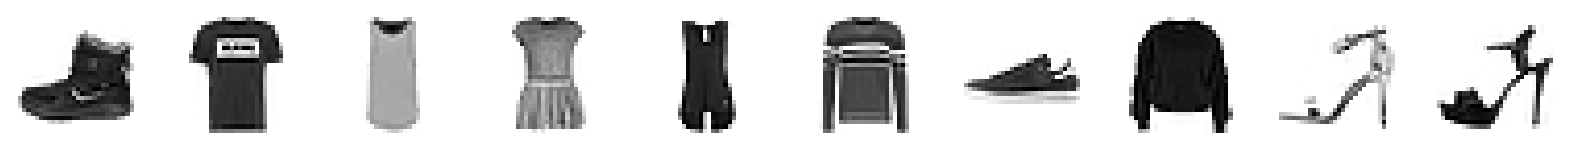

In [19]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the autoencoder <a name="build"></a>

## Mathematical Overview

In an *Autoencoder*, the idea is to train an *Encoder* to embed the input $\mathbf{x}$ into a smaller *Latent Space*, $\mathbf{z}$, and then the *Decoder* takes as input this encoding and reconstructs the object.

This connection happens here: 

$$ \texttt{ x = layers.Flatten()(x)} $$
$$ \texttt{encoder\_output = layers.Dense(EMBEDDING\_DIM, name="encoder\_output")(x)} $$

After downsampling, we connect the flattened feature map to a 2D vector.

Let $g_{\phi}$ be the encoder. Then, $\mathbf{z}=g_{\phi}(\mathbf{x})$. With $f_{\theta}$ as the decoder, this gives us $\hat{\mathbf{x}}=f_{\theta}(\mathbf{z})=f_{\theta}(g_{\phi}(\mathbf{x}))$

We can then use whatever loss function, perhaps *Mean Squared Error*, defined below, as the loss function.

$$ \mathcal{L}_{\theta, \phi}(X)=\frac{1}{|X|} \sum_{\mathbf{x} \in X} l(\mathbf{x}, \hat{\mathbf{x}}) $$
$$ \mathcal{L}_{\theta, \phi}(X)=\frac{1}{|X|} \sum_{\mathbf{x} \in X} (\mathbf{x} - f_{\theta}(g_{\phi}(\mathbf{x})))^2 $$

Graphically, this looks like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/Autoencoder.png' alt='Autoencoder' width='500'>
</div>

Now, once we have the smaller embedded "image", how do we build it back up? We are going to use *Transpose Convolution Layers*. This essentially does the opposite of the regular convolution layer and whereas the strides determine how the regular convolution will shrink the input, in this case, the strides increase the size of the input.

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/Transpose_Convolution.png' alt='Transpose_Convolution' width='500'>
</div>

In [6]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # This is the last non-flat shape the image ends up as. We are going to use this to rebuild our image
# from our latent space. The [1:] is because we are removing the batch shape

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

2023-07-05 18:55:04.658317: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-05 18:55:04.658347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: OPH-M-DF98PS3L
2023-07-05 18:55:04.658352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: OPH-M-DF98PS3L
2023-07-05 18:55:04.658506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-07-05 18:55:04.658522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-07-05 18:55:04.658526: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.105.17 does not match DSO version 525.125.6 -- cannot find working devices in this configuration
2023-07-05 18:55:04.658801: I tensorflow/core/platform/cpu_feature_guard.cc:19

In [7]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input") # Our input is the embedded shape (2, in this case)
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) # We now connect our embedded shape to the flattened last "image"-like 
# shape the image had in the encoder
x = layers.Reshape(shape_before_flattening)(x) # We reshape that flattened "image"-like shape into an "image"-like object to begin rebuilding it
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

In [8]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## 3. Train the autoencoder <a name="train"></a>

In [9]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [10]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [11]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2958

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 32s 53ms/step - loss: 0.2958 - val_loss: 0.2653
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2602

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 31s 52ms/step - loss: 0.2602 - val_loss: 0.2588
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.2554

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 30s 50ms/step - loss: 0.2554 - val_loss: 0.2559


In [20]:
# Save the final models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [21]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 7ms/step
Example real clothing items


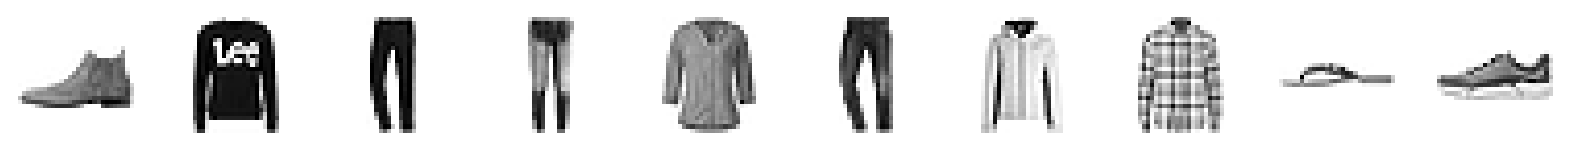

Reconstructions


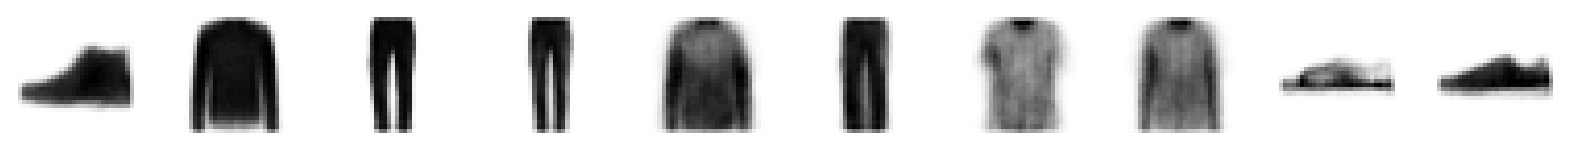

In [22]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

In [23]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 1ms/step


In [24]:
# Some examples of the embeddings
print(embeddings[:10])

[[ 2.94799     3.664655  ]
 [-1.7511418  -2.5595694 ]
 [10.855864   -9.88819   ]
 [10.547236   -6.832219  ]
 [ 0.17959297 -1.0937936 ]
 [ 5.830095   -5.8201046 ]
 [ 2.1984906  -1.7030128 ]
 [ 0.89466786 -1.4339366 ]
 [ 7.204238    2.2537355 ]
 [ 6.159786    3.518496  ]]


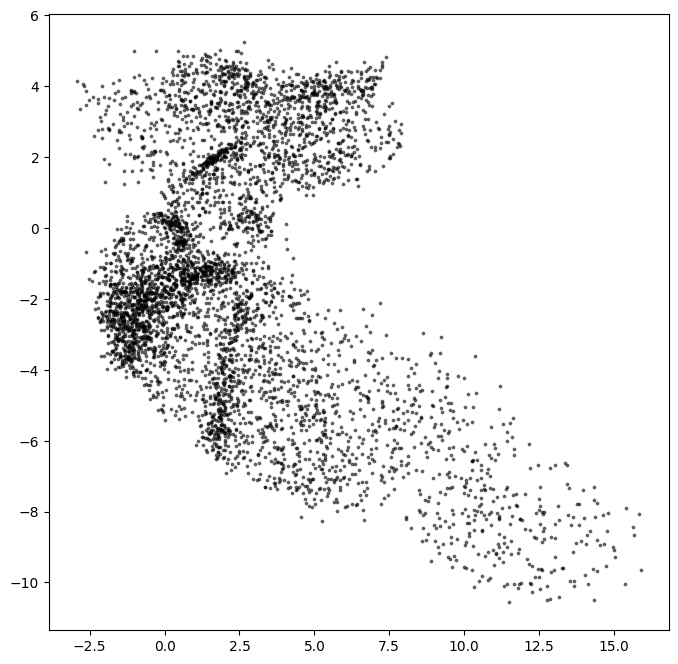

In [25]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

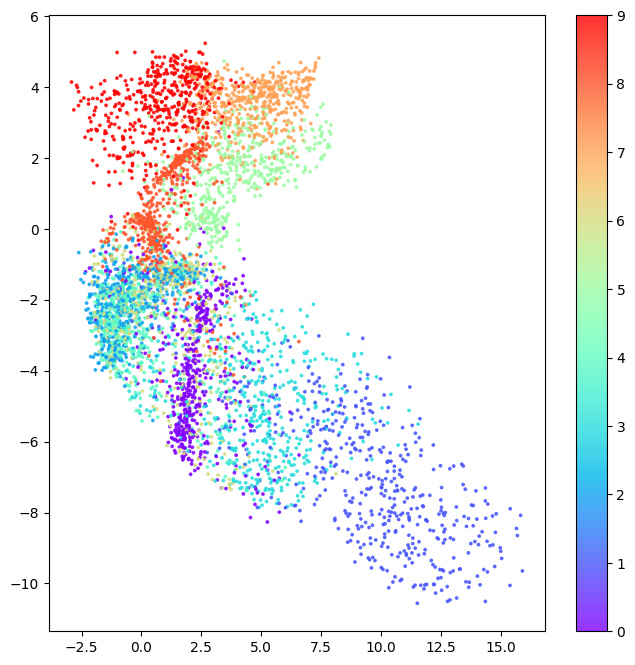

In [26]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generate using the decoder <a name="decode"></a>

In [27]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [28]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 73ms/step


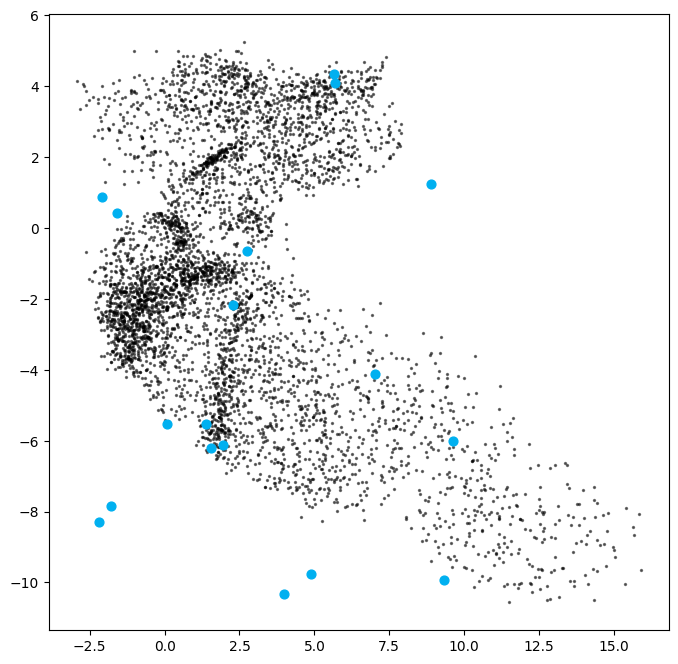

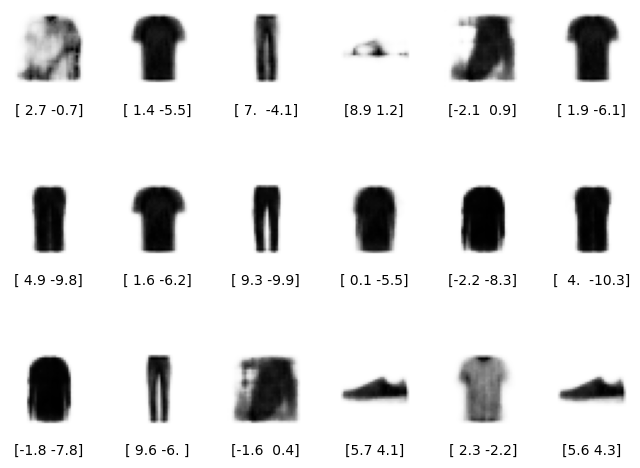

In [29]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 8ms/step


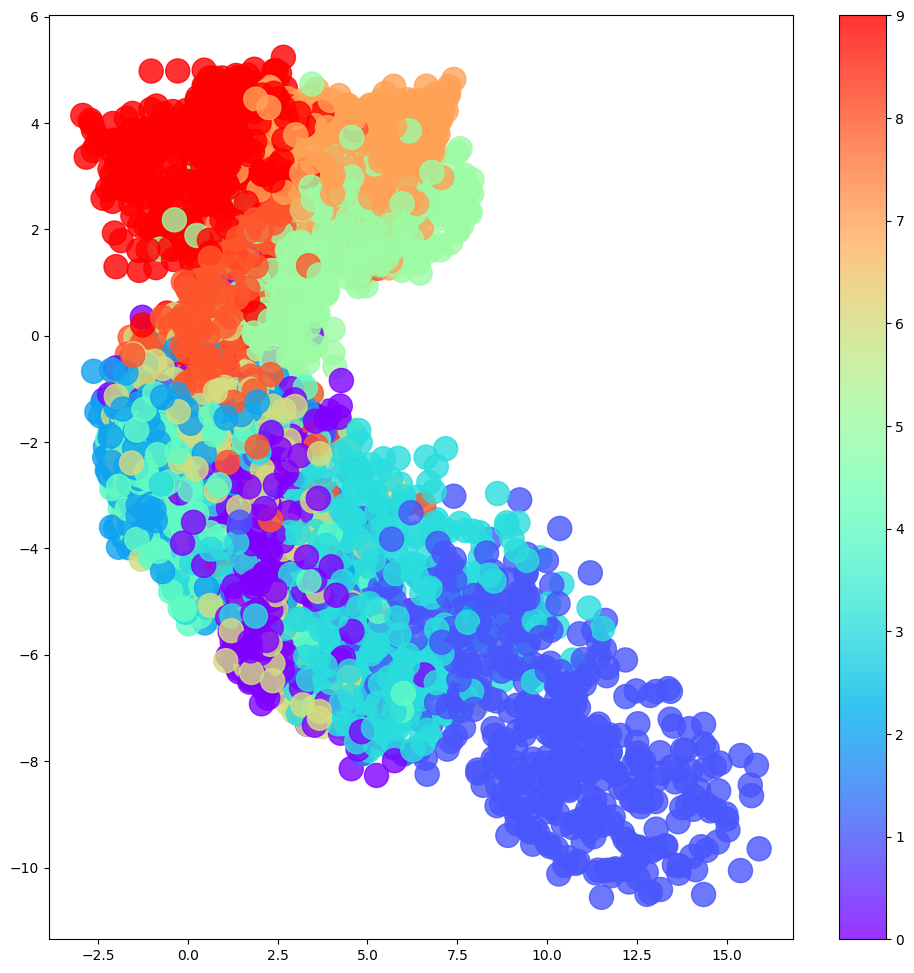

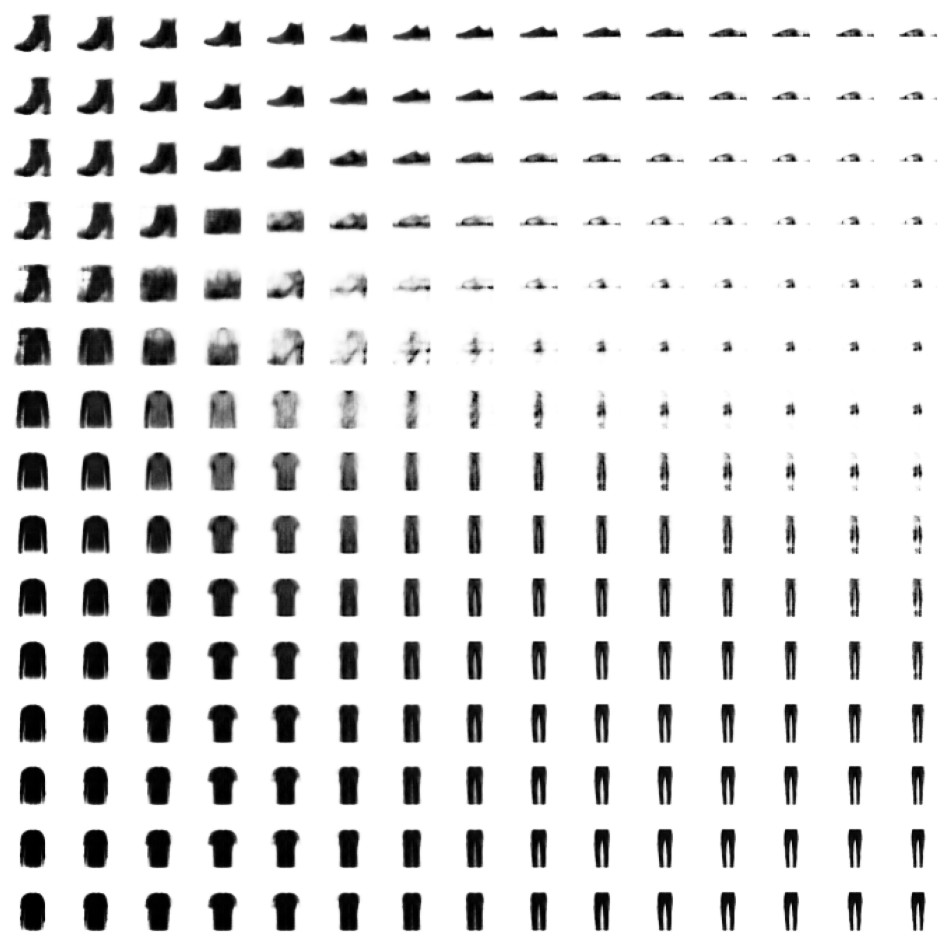

In [30]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")